# This notebook show the effect of image quality on object detection using Yolo v8 on KITTI dataset 

In [1]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
import pandas as pd
import openpyxl
import torch
import matplotlib.pyplot as plt
import seaborn as sns

ERROR setting UTF-8 encoding: 'OutStream' object has no attribute 'buffer'


## Initialization for some required parameter

In [2]:
image_path=r"C:\Users\User\OneDrive\Desktop\Master Thesis\Yolo_study\Left_image\000344.png"
depth_map_txt=r"C:\Users\User\OneDrive\Desktop\Master Thesis\Yolo_study\Left_image\000344_depthmap.txt"
image_name,_=os.path.splitext(os.path.basename(image_path))
saving_directory=f"E:\yolo_study_depth\Yolov8_dp\{image_name}"
excel_file=r'E:\yolo_study_depth\yolopredication.xlsx'
print(saving_directory)

E:\yolo_study_depth\Yolov8_dp\000344


In [3]:
# Read the depth map from the text file
with open(depth_map_txt, 'r') as file:
    depth_map_list = [list(map(float, line.split())) for line in file]
depth_map_array = np.array(depth_map_list)

In [4]:
image=cv2.imread(image_path)
image_size=image.shape[:2]
print(f"Original Image size= {image_size}")

Original Image size= (375, 1242)


In [5]:
initial_prob=0.001 #0.1% of the pixels are dead
final_prob=1       #100% of the pixels are dead
number_of_steps=75  # the number of images to study
step_value=(final_prob-initial_prob)/number_of_steps

print(f"The increase in the deadpixel percentage is {round(step_value*100)}% ")

The increase in the deadpixel percentage is 1% 


## Importing the Yolov8x model

In [6]:
model = YOLO('yolov8x.pt')

## Required Functions

In [7]:
# Initialize the persistent dead pixels mask
persistent_dead_pixels = np.zeros(image_size, dtype=bool)

In [8]:
def dead_pixel_generation(dp_prob, persistent_mask):
    # Generate new dead pixels, only where there are no dead pixels already
    new_dead_pixels = (np.random.rand(*image_size) < dp_prob) & ~persistent_mask
    # Update the persistent mask to include the new dead pixels
    persistent_mask |= new_dead_pixels
    dead_pixel_coordinates = np.argwhere(persistent_mask)
    number_of_dead_pixels = len(dead_pixel_coordinates)
    return dead_pixel_coordinates, number_of_dead_pixels, persistent_mask

In [9]:
def image_with_dp(img, dp_coor,s,saving_dir):
    for coordinates in dp_coor:
        row, col=coordinates
        img[row][col]=[0,0,0]
    new_image_name=f"{image_name}_dp_{s}.jpg"
    image_file_dir=os.path.join(saving_dir,new_image_name)
    cv2.imwrite(image_file_dir,img)
    return image_file_dir,new_image_name
    

In [10]:
def get_distances(depth_map, bbox, method):
#     print(bbox[0:2])
    pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
    pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

    # get center location on image
    x_center = np.round((pt1[1] + pt2[1]) / 2).astype(int)
    y_center = np.round((pt1[0] + pt2[0]) / 2).astype(int)
    #print("pt1",pt1[1])
    # get depth slice
    depth_slice = depth_map[pt1[1]:pt2[1], pt1[0]:pt2[0]]

    # compute median depth to get the distance
    if method == 'center':
        x_c = np.round((pt2[1] - pt1[1]) / 2).astype(int)
        y_c = np.round((pt2[0] - pt1[0]) / 2).astype(int)
        stereo_depth = depth_slice[x_c, y_c]
    else:
        stereo_depth = np.median(depth_slice) 
        
    return stereo_depth

In [11]:
def results_to_list(img_name,dp_prob,prediction_results,original):
    class_info_list=[]
    for result in prediction_results:
        classes=result.boxes.cls
        confedance=result.boxes.conf
        box_coordinats=result.boxes.xyxy
        speed_detection=result.speed
    for i in range(len(classes)):
        object_depth=get_distances(depth_map_array,box_coordinats[i],method='median')
        box_center_coordinate_x,box_center_coordinate_y=box_center_cal(box_coordinats[i])
        if original:
            class_info_list.append([str(img_name),float(dp_prob),int(classes.data[i]),float(confedance[i]),tuple([round(float(box_center_coordinate_x),0),round(float(box_center_coordinate_y),0)]),box_coordinats[i],object_depth,i])
        else:
            class_info_list.append([str(img_name),float(dp_prob),int(classes.data[i]),float(confedance[i]),tuple([round(float(box_center_coordinate_x),0),round(float(box_center_coordinate_y),0)]),box_coordinats[i]])
    return class_info_list

In [12]:
def fill_missing_classes(original_list, filtered_list, img, pd_prob):
    modified_filtered_list = []
    used_filtered_indices = set()  # Track items that have been matched

    # Define maximum allowed differences for position and size
    max_position_difference = 50
    max_size_difference = 50

    # Iterate through each original item
    for original_index, original_item in enumerate(original_list):
        closest_match = None
        closest_match_index = None
        smallest_difference = float('inf')

        # Iterate through each item to find the closest match
        for filtered_index, filtered_item in enumerate(filtered_list):
            if filtered_index in used_filtered_indices:
                continue  # Skip this item if it has been used

            if original_item[2] == filtered_item[2]:  # Check if classes match
                # Calculate the total difference based on position and size
                position_difference = abs(original_item[4][0] - filtered_item[4][0]) + abs(original_item[4][1] - filtered_item[4][1])
                size_difference = abs(original_item[5][2] - filtered_item[5][2]) + abs(original_item[5][3] - filtered_item[5][3])

                # Check if the differences are within the maximum allowed
                if position_difference <= max_position_difference and size_difference <= max_size_difference:
                    total_difference = position_difference + size_difference
                    
                    # If this item is the closest match so far, record it
                    if total_difference < smallest_difference:
                        closest_match = filtered_item
                        closest_match_index = filtered_index
                        smallest_difference = total_difference
        
        # If a closest match within the thresholds was found, add to the modified list
        if closest_match is not None:
            used_filtered_indices.add(closest_match_index)  # Mark this item as used
            original_depth = original_item[6]
            modified_item = closest_match[:]  # Create a copy to avoid modifying the original
            modified_item.insert(6, original_depth)  # Insert original depth
            modified_item.insert(7, original_index)  # Insert original index
            modified_filtered_list.append(modified_item)
        else:
            # No suitable match found within the bounds, add a placeholder
            modified_filtered_list.append([img,pd_prob,"No_detected", 0, (0, 0),(0,0,0,0),0,original_list.index(original_item)])

    return modified_filtered_list

In [13]:
def box_center_cal(box_coord):
    x_box_coordinates=(box_coord[0]+box_coord[2])/2
    y_box_coordinates=(box_coord[1]+box_coord[3])/2
    return x_box_coordinates,y_box_coordinates


In [14]:
def saving_excel(file_path, sheet_name, predication_results_info):
    if sheet_name=="Dp_study":
        headers=["Image_name","Dead_pixels_Prop","Class","Confidance","Center_of_object","Box_coordinats_xyxy","Object_Depth","Index_to_origin"]
    elif sheet_name=="Blur_study":
        headers=["Image_name","Main_image_name","Kernal_size","Sigma_value","Class","Confidance","Center_of_object","Box_coordinats_xyxy","Object_Depth","Index_to_origin"]
    elif sheet_name =="Pnoise_study_normal":
        headers=["Image_name","Main_image","K_value","B_value","Class","Confidance","Center_of_object","Box_coordinats_xyxy","Object_Depth","Index_to_origin"]
    elif sheet_name =="Pnoise_study_dark":
        headers=["Image_name","Main_image","K_value","B_value","Class","Confidance","Center_of_object","Box_coordinats_xyxy","Object_Depth","Index_to_origin"]
    elif sheet_name== "Gnoise_study":
        headers=["Image_name","Main_image","Sigma_value","Mean_value","Class","Confidance","Center_of_object","Box_coordinats_xyxy","Object_Depth","Index_to_origin"]
    
    try:
        workbook = openpyxl.load_workbook(file_path)
    except FileNotFoundError:
        workbook = openpyxl.Workbook()

    if sheet_name in workbook.sheetnames:
        sheet = workbook[sheet_name]
    else:
        sheet = workbook.create_sheet(title=sheet_name)
    
    next_row = sheet.max_row
    
    if next_row ==1:
        sheet.append(headers)
    
    for row_data in predication_results_info:
        row_data = [str(value) for value in row_data]
        sheet.append(row_data)
        
    workbook.save(file_path)


In [15]:
def saving_summary_excel(image_name,main_image, file_path, row_data):
    # Assuming row_data[0].verbose() returns a string of comma-separated values
    log = row_data[0].verbose()
    log = list(log.split(","))
    while ' ' in log:
        log.remove(' ')

    # Preparing new data to be appended
    new_data = {"Image Name": image_name, "Main Image Name": main_image,"Detection Results": [log]}
    df_new = pd.DataFrame(new_data)

    sheet_name = "Summary"

    try:
        with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
            if sheet_name in writer.sheets:
                df_existing = pd.read_excel(file_path, sheet_name=sheet_name)
                df_final = pd.concat([df_existing, df_new], ignore_index=True)
            else:
                # If the sheet does not exist, just use the new data
                df_final = df_new
            
            df_final.to_excel(writer, sheet_name=sheet_name, index=False)

    except FileNotFoundError:
        # If the file does not exist, create it with the new data
        df_new.to_excel(file_path, sheet_name=sheet_name, index=False)


## Original Image processing

In [16]:
results_original= model(image,save=True, project=saving_directory, name="OriginalImage",save_txt=True, save_conf=True, )  # predict on an image


0: 224x640 5 cars, 1371.1ms
Speed: 13.1ms preprocess, 1371.1ms inference, 6.3ms postprocess per image at shape (1, 3, 224, 640)
Results saved to E:\yolo_study_depth\Yolov8_dp\000344\OriginalImage
1 label saved to E:\yolo_study_depth\Yolov8_dp\000344\OriginalImage\labels


In [17]:
names=results_original[0].names
#print(names)

In [18]:
original_image_class_list=results_to_list(image_name,int(0),results_original,True)

In [19]:
saving_summary_excel(image_name,image_name,excel_file,results_original)
saving_excel(excel_file,"Dp_study",original_image_class_list)

## Adding dead pixels and study the effect

In [20]:
dp_probability = initial_prob
step = 0
total = 0
for x in range(number_of_steps + 1):
    dp_coordinates, number_of_dp, persistent_dead_pixels = dead_pixel_generation(dp_probability, persistent_dead_pixels)
    # Further image processing and analysis
    img_file_dir, new_img = image_with_dp(image, dp_coordinates, step, saving_directory)
    projectname = os.path.splitext(new_img)[0]
    results_dp_filtered = model(img_file_dir, save=True, project=saving_directory, name=projectname, save_txt=True, save_conf=True)
    results_in_list = results_to_list(new_img, dp_probability, results_dp_filtered, False)
    total += len(results_in_list)
    full_dp_list = fill_missing_classes(original_image_class_list, results_in_list, new_img, dp_probability)
    saving_summary_excel(new_img, image_name, excel_file, results_dp_filtered)
    saving_excel(excel_file, "Dp_study", full_dp_list)
    dp_probability += step_value
    step += 1

print("total detected dp test=", total)
    


image 1/1 E:\yolo_study_depth\Yolov8_dp\000344\000344_dp_0.jpg: 224x640 5 cars, 995.0ms
Speed: 0.0ms preprocess, 995.0ms inference, 3.0ms postprocess per image at shape (1, 3, 224, 640)
Results saved to E:\yolo_study_depth\Yolov8_dp\000344\000344_dp_0
1 label saved to E:\yolo_study_depth\Yolov8_dp\000344\000344_dp_0\labels

image 1/1 E:\yolo_study_depth\Yolov8_dp\000344\000344_dp_1.jpg: 224x640 5 cars, 1081.6ms
Speed: 1.9ms preprocess, 1081.6ms inference, 10.0ms postprocess per image at shape (1, 3, 224, 640)
Results saved to E:\yolo_study_depth\Yolov8_dp\000344\000344_dp_1
1 label saved to E:\yolo_study_depth\Yolov8_dp\000344\000344_dp_1\labels

image 1/1 E:\yolo_study_depth\Yolov8_dp\000344\000344_dp_2.jpg: 224x640 5 cars, 910.1ms
Speed: 2.2ms preprocess, 910.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)
Results saved to E:\yolo_study_depth\Yolov8_dp\000344\000344_dp_2
1 label saved to E:\yolo_study_depth\Yolov8_dp\000344\000344_dp_2\labels

image 1/1 E:\yolo_

## Studying the blur effect on the detection

OpenCV provides four main types of blurring techniques:
    1. Averaging
    2. Gaussian Blurring
    3. Median Blurring
    4. Bilateral Filtering
    
 Gaussian Blurring is the closest to the real blur that occurs due to camera sensor degradation


In [ ]:
original_image=cv2.imread(image_path)

### Functions for blur study
Note: After applying kernals and sigma arbitrary. The effect of blur was not notaible for some sigma and kernals (the results are available in deadsecondtry note), So this rule had been applied 
Kernel_size=2(3*sigma)+1
So for each sigam there are one kernal

In [ ]:
def results_to_list_blur(blured_image_name,main_image,kernal_size, sigma_value,prediction_blured_results,original):
    class_blured_info_list=[]
    for result in prediction_blured_results:
        classes=result.boxes.cls
        confedance=result.boxes.conf
        box_coordinats=result.boxes.xyxy
        box_coordinats_xywh=result.boxes.xywh
    for i in range(len(classes)):
        box_center_coordinate_x,box_center_coordinate_y=box_center_cal(box_coordinats[i])
        object_depth=get_distances(depth_map_array,box_coordinats[i],method='median')
        if original:
            class_blured_info_list.append([str(blured_image_name),str(main_image),kernal_size,int(sigma_value),int(classes.data[i]),float(confedance[i]),tuple([round(float(box_center_coordinate_x),0),round(float(box_center_coordinate_y),0)]),box_coordinats_xywh[i],object_depth,i])
        else:
            class_blured_info_list.append([str(blured_image_name),str(main_image),kernal_size,int(sigma_value),int(classes.data[i]),float(confedance[i]),tuple([round(float(box_center_coordinate_x),0),round(float(box_center_coordinate_y),0)]),box_coordinats_xywh[i]])
    return class_blured_info_list

In [ ]:
def fill_missing_classes_blured(original_list, blurred_list, img, kernel_size, sigma_value,main_image):
    modified_blurred_list = []
    used_blurred_indices = set()  # Track blurred items that have been matched

    # Define maximum allowed differences for position and size
    max_position_difference = 35
    max_size_difference = 45

    # Iterate through each original item
    for original_index, original_item in enumerate(original_list):
        closest_match = None
        closest_match_index = None
        smallest_difference = float('inf')

        # Iterate through each blurred item to find the closest match
        for blurred_index, blurred_item in enumerate(blurred_list):
            if blurred_index in used_blurred_indices:
                continue  # Skip this blurred item if it has been used

            if original_item[4] == blurred_item[4]:  # Check if classes match
                # Calculate the total difference based on position and size
                position_difference = abs(original_item[6][0] - blurred_item[6][0]) + abs(original_item[6][1] - blurred_item[6][1])
                size_difference = abs(original_item[7][2] - blurred_item[7][2]) + abs(original_item[7][3] - blurred_item[7][3])

                # Check if the differences are within the maximum allowed
                if position_difference <= max_position_difference and size_difference <= max_size_difference:
                    total_difference = position_difference + size_difference
                    
                    # If this blurred item is the closest match so far, record it
                    if total_difference < smallest_difference:
                        closest_match = blurred_item
                        closest_match_index = blurred_index
                        smallest_difference = total_difference
        
        # If a closest match within the thresholds was found, add to the modified list
        if closest_match is not None:
            used_blurred_indices.add(closest_match_index)  # Mark this blurred item as used
            original_depth = original_item[8]
            modified_item = closest_match[:]  # Create a copy to avoid modifying the original
            modified_item.insert(8, original_depth)  # Insert original depth
            modified_item.insert(9, original_index)  # Insert original index
            modified_blurred_list.append(modified_item)
        else:
            # No suitable match found within the bounds, add a placeholder
            modified_blurred_list.append([img,main_image, kernel_size, sigma_value, "No_detected", 0, (0, 0), 0, 0, original_index])

    return modified_blurred_list


Original image analysis before starting with applying the filter

In [ ]:
before_blur_results=results_to_list_blur(image_name,image_name,(0,0),0,results_original,True)

In [ ]:
saving_excel(excel_file,"Blur_study",before_blur_results)

In [ ]:
initial_sigma=0
final_sigma=15
step_sigma=1

for sigma in range(initial_sigma,final_sigma+1,step_sigma):
    kernal_value=2*(3*sigma)+1
    kernal=(kernal_value,kernal_value)
    #print(kernal)
    new_bluredimg_name=f"blured_{kernal}_{sigma}.jpg"
    new_bluredimg=os.path.join(saving_directory,new_bluredimg_name)
    #print(new_bluredimg)
    projectname=os.path.splitext(new_bluredimg_name)[0]
    blured_image=cv2.GaussianBlur(original_image,kernal,sigma)
    cv2.imwrite(new_bluredimg,blured_image)
    results_blured = model(new_bluredimg,save=True, project=saving_directory, name=projectname,save_txt=True, save_conf=True)
    results_list_blur=results_to_list_blur(new_bluredimg_name,image_name,kernal,sigma,results_blured,False)

    full_blured_list=fill_missing_classes_blured(before_blur_results,results_list_blur,new_bluredimg_name,kernal,sigma,image_name)

    saving_excel(excel_file,"Blur_study",full_blured_list)
    saving_summary_excel(new_bluredimg_name,image_name,excel_file,results_blured)
print("Done blur testing")

## Poisson noise study

The number of photons hitting a pixel during the exposure time fluctuates statistically. According to the laws of quantum mechanics, the probability is Poisson distributed. This noise, often referred to as shot noise is given by the basic laws of physics.
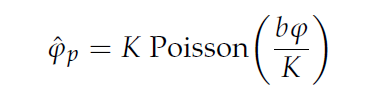

b: is for adjusting the brightness
<br>K: The image sensor gain that converts electrons into digit values is represented by this parameter, which is exclusively dependent on the sensor performance. With the aim of analysing realistic scenarios, different commercial vision sensor data-sheets have been collected, where K goes from 0.01 to 0.1 DN/e−. Furthermore, in order to study those more complex situations, higher values for K have been considered.
<br> The conversion from analog information to digital data converts the voltage signal into digital numbers (DN) which is the overall gain K factor (K = χξ)
<br> Furthermore, this degradation is more perceptible for the lowest values of the bright scale low b
<br> The normal DN/e- for our camera is 

In [ ]:
def add_poisson_noise(image, b, K):
    image_float = image.astype(np.float32)
    # Adjust the image by the brightness scale factor b
    bright_scaled_image = b * image_float
    noisy_image = K * np.random.poisson(bright_scaled_image / K)
    # Clip the values to the range [0, K] and return to original data type
    noisy_image = np.clip(noisy_image, 0, 255).astype(image.dtype)
    return noisy_image

### Necessary functions

In [ ]:
def dark_image(image, brightness_factor):
    # Ensure the brightness factor is within a valid range
    brightness_factor = max(0, min(1, brightness_factor))
    
    # Reduce the brightness of the image
    darker_image = (image.astype(np.float32) * brightness_factor)
    
    return darker_image

In [ ]:
def results_to_list_pnoised(pnoised_image_name,main_image,k_value,b_value,prediction_pnoised_results,original):
    class_pnoised_info_list=[]
    for result in prediction_pnoised_results:
        classes=result.boxes.cls
        confedance=result.boxes.conf
        box_coordinats=result.boxes.xyxy
    for i in range(len(classes)):
        box_center_coordinate_x,box_center_coordinate_y=box_center_cal(box_coordinats[i])
        object_depth=get_distances(depth_map_array,box_coordinats[i],method='median')
        if original:
            class_pnoised_info_list.append([str(pnoised_image_name),str(main_image),int(k_value),b_value,int(classes.data[i]),float(confedance[i]),tuple([round(float(box_center_coordinate_x),0),round(float(box_center_coordinate_y),0)]),box_coordinats[i],object_depth,i])
        else:
            class_pnoised_info_list.append([str(pnoised_image_name),str(main_image),int(k_value),b_value,int(classes.data[i]),float(confedance[i]),tuple([round(float(box_center_coordinate_x),0),round(float(box_center_coordinate_y),0)]),box_coordinats[i]])
    return class_pnoised_info_list

In [ ]:
def fill_missing_classes_pnoised(original_list, pnoised_list,img,k_value,b_value,main_image):
    modified_pnosied_list = []
    used_pnosied_indices = set()  # Track items that have been matched

    # Define maximum allowed differences for position and size
    max_position_difference = 35
    max_size_difference = 35

    # Iterate through each original item
    for original_index, original_item in enumerate(original_list):
        closest_match = None
        closest_match_index = None
        smallest_difference = float('inf')

        # Iterate through each item to find the closest match
        for pnoised_index, pnoised_item in enumerate(pnoised_list):
            if pnoised_index in used_pnosied_indices:
                continue  # Skip this item if it has been used

            if original_item[4] == pnoised_item[4]:  # Check if classes match
                # Calculate the total difference based on position and size
                position_difference = abs(original_item[6][0] - pnoised_item[6][0]) + abs(original_item[6][1] - pnoised_item[6][1])
                size_difference = abs(original_item[7][2] - pnoised_item[7][2]) + abs(original_item[7][3] - pnoised_item[7][3])

                # Check if the differences are within the maximum allowed
                if position_difference <= max_position_difference and size_difference <= max_size_difference:
                    total_difference = position_difference + size_difference
                    
                    # If this item is the closest match so far, record it
                    if total_difference < smallest_difference:
                        closest_match = pnoised_item
                        closest_match_index = pnoised_index
                        smallest_difference = total_difference
        
        # If a closest match within the thresholds was found, add to the modified list
        if closest_match is not None:
            used_pnosied_indices.add(closest_match_index)  # Mark this item as used
            original_depth = original_item[8]
            modified_item = closest_match[:]  # Create a copy to avoid modifying the original
            modified_item.insert(8, original_depth)  # Insert original depth
            modified_item.insert(9, original_index)  # Insert original index
            modified_pnosied_list.append(modified_item)      
        else:
            # No suitable match found within the bounds, add a placeholder
            modified_pnosied_list.append([img,main_image,k_value,b_value,"No_detected", 0, (0, 0),0,0,original_list.index(original_item)])

    return modified_pnosied_list


**Original image analysis before starting with applying the noise**

In [ ]:
before_pnoise_results=results_to_list_pnoised(image_name,image_name,0,1,results_original,True)

In [ ]:
saving_excel(excel_file,"Pnoise_study_normal",before_pnoise_results)

**Adding poisson noise to the original image without changing the brigtness**

In [ ]:
initial_k = 2
final_k = 74
step_k = 8
B = 1

current_image = original_image.copy()  # Make a copy to keep the original image unchanged

for k in range(initial_k, final_k + 8, step_k):
    new_pnoisedimg_name = f"pnoised_{k}_{B}.jpg"
    new_pnoisedimg = os.path.join(saving_directory, new_pnoisedimg_name)
    projectname = os.path.splitext(new_pnoisedimg_name)[0]
    
    # Apply Poisson noise to the current image state
    pnoised_image = add_poisson_noise(current_image, b=B, K=step_k)
    
    # Save the noised image for this iteration
    cv2.imwrite(new_pnoisedimg, pnoised_image)
    
    # Update the current image with the just generated noised image for the next iteration
    current_image = pnoised_image.copy()
    
    results_pnoised = model(new_pnoisedimg, save=True, project=saving_directory, name=projectname, save_txt=True, save_conf=True)
    results_list_pnoise = results_to_list_pnoised(new_pnoisedimg_name, image_name, k, B, results_pnoised, False)

    full_pnoised_list = fill_missing_classes_pnoised(before_pnoise_results, results_list_pnoise, new_pnoisedimg_name, k, B, image_name)

    saving_excel(excel_file, "Pnoise_study_normal", full_pnoised_list)
    saving_summary_excel(new_pnoisedimg_name, image_name, excel_file, results_pnoised)

print("Done Poisson noise test")

# Gaussian noise study

In image processing and computer vision, noise refers to random variations of brightness or color information in images. It's an unavoidable aspect of digital imaging, often introduced during image acquisition (e.g., sensor noise in low light) or transmission. One common model for representing noise is Gaussian noise, also known as normal noise, due to its adherence to the Gaussian (normal) distribution. <br>

**Mean (μ)**: A non-zero mean can make the noise either predominantly positive or negative.
<br>**Standard Deviation (σ)**: Controls the amplitude of the noise. Low σ values produce subtler noise, maintaining the image's integrity, while high σ values can significantly alter the image's appearance, potentially obscuring details

In [ ]:
def add_gaussian_noise(image, brightness_factor, mean, sigma):
    """
    Modifies an image by reducing its brightness and adding Gaussian noise.
    
    Parameters:
        image: Input image.
        brightness_factor: Factor by which to reduce the brightness (0 < factor < 1).
        mean: Mean of the Gaussian noise.
        sigma: Standard deviation of the Gaussian noise.
    """
    # Ensure the brightness factor is within a valid range
    brightness_factor = max(0, min(1, brightness_factor))
    
    # Reduce the brightness of the image
    darker_image = (image.astype(np.float32) * brightness_factor)
    
    # Get the dimensions of the image
    row, col, ch = image.shape
    
    # Generate Gaussian noise
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    
    # Add the Gaussian noise to the darker image
    noisy = darker_image + gauss
    
    # Clip values to be in the valid range and convert back to an 8-bit unsigned integer
    noisy= np.clip(noisy, 0, 255).astype(np.uint8)
    
    return noisy


In [ ]:
def results_to_list_gnoised(gnoised_image_name,main_image,sigma,mean,prediction_gnoised_results,original):
    class_gnoised_info_list=[]
    for result in prediction_gnoised_results:
        classes=result.boxes.cls
        confedance=result.boxes.conf
        box_coordinats=result.boxes.xyxy
    for i in range(len(classes)):
        box_center_coordinate_x,box_center_coordinate_y=box_center_cal(box_coordinats[i])
        object_depth=get_distances(depth_map_array,box_coordinats[i],method='median')
        if original:
            class_gnoised_info_list.append([str(gnoised_image_name),str(main_image),int(sigma),int(mean),int(classes.data[i]),float(confedance[i]),tuple([round(float(box_center_coordinate_x),0),round(float(box_center_coordinate_y),0)]),box_coordinats[i],object_depth,i])
        else:
            class_gnoised_info_list.append([str(gnoised_image_name),str(main_image),int(sigma),int(mean),int(classes.data[i]),float(confedance[i]),tuple([round(float(box_center_coordinate_x),0),round(float(box_center_coordinate_y),0)]),box_coordinats[i]])
    return class_gnoised_info_list

In [ ]:
def fill_missing_classes_gnoised(original_list, gnoised_list,img,sigma_value,mean_value,main_image):
    modified_gnosied_list = []
    used_gnosied_indices = set()  # Track items that have been matched

    # Define maximum allowed differences for position and size
    max_position_difference = 40
    max_size_difference = 40

    # Iterate through each original item
    for original_index, original_item in enumerate(original_list):
        closest_match = None
        closest_match_index = None
        smallest_difference = float('inf')

        # Iterate through each item to find the closest match
        for gnoised_index, gnoised_item in enumerate(gnoised_list):
            if gnoised_index in used_gnosied_indices:
                continue  # Skip this item if it has been used

            if original_item[4] == gnoised_item[4]:  # Check if classes match
                # Calculate the total difference based on position and size
                position_difference = abs(original_item[6][0] - gnoised_item[6][0]) + abs(original_item[6][1] - gnoised_item[6][1])
                size_difference = abs(original_item[7][2] - gnoised_item[7][2]) + abs(original_item[7][3] - gnoised_item[7][3])

                # Check if the differences are within the maximum allowed
                if position_difference <= max_position_difference and size_difference <= max_size_difference:
                    total_difference = position_difference + size_difference
                    
                    # If this item is the closest match so far, record it
                    if total_difference < smallest_difference:
                        closest_match = gnoised_item
                        closest_match_index = gnoised_index
                        smallest_difference = total_difference
        
        # If a closest match within the thresholds was found, add to the modified list
        if closest_match is not None:
            used_gnosied_indices.add(closest_match_index)  # Mark this item as used
            original_depth = original_item[8]
            modified_item = closest_match[:]  # Create a copy to avoid modifying the original
            modified_item.insert(8, original_depth)  # Insert original depth
            modified_item.insert(9, original_index)  # Insert original index
            modified_gnosied_list.append(modified_item)      
        else:
            # No suitable match found within the bounds, add a placeholder
            modified_gnosied_list.append([img,main_image,sigma_value,mean_value,"No_detected", 0, (0, 0),0,0,original_list.index(original_item)])

    return modified_gnosied_list

**Original image analysis before starting with applying the gaussian noise**

In [ ]:
before_gnoise_results=results_to_list_gnoised(image_name,image_name,0,0,results_original,True)

In [ ]:
saving_excel(excel_file,"Gnoise_study",before_gnoise_results)

**Adding gaussian noise to the original image**

In [ ]:
initial_sigma=2
final_sigma=50
step_sigma=4
mean_value=0
current_image = original_image.copy()

for sigma in range(initial_sigma,final_sigma+4,step_sigma):
    new_gnoisedimg_name=f"gnoised_{sigma}.jpg"
    new_gnoisedimg=os.path.join(saving_directory,new_gnoisedimg_name)
    projectname=os.path.splitext(new_gnoisedimg_name)[0]
    
    gnoised_image=add_gaussian_noise(current_image,brightness_factor=1,mean=mean_value,sigma=sigma)
    cv2.imwrite(new_gnoisedimg,gnoised_image)
    
    current_image = gnoised_image.copy()
    
    results_gnoised = model(new_gnoisedimg,save=True, project=saving_directory, name=projectname,save_txt=True, save_conf=True)
    results_list_gnoise=results_to_list_gnoised(new_gnoisedimg_name,image_name,sigma,mean_value,results_gnoised,False)

    full_gnoised_list=fill_missing_classes_gnoised(before_gnoise_results,results_list_gnoise,new_gnoisedimg_name,sigma,mean_value,image_name)

    saving_excel(excel_file,"Gnoise_study",full_gnoised_list)
    saving_summary_excel(new_gnoisedimg_name,image_name,excel_file,results_gnoised)
    
print("Done Gaussian noise test")

## Post-processing for the study

### Dead pixels study

In [ ]:
postdf=pd.read_excel(excel_file,sheet_name="Dp_study")

In [ ]:
postdf.head()

In [ ]:
postdf.describe()

In [ ]:
postdf.describe(include="object")

In [ ]:
postdf[postdf['Class']=="No_detected"]

In [ ]:
plt.figure(figsize=(25,10))
sns.lineplot(x='Dead_pixels_Prop', y='Confidance',hue='unique_id', estimator=None, data=postdf,palette="bright").set_title("Impact of dead pixels on class detection Confidance")
plt.show()

In [ ]:
postdf['Object_Depth'] = pd.to_numeric(postdf['Object_Depth'], errors='coerce')

In [ ]:
depth_ranges = [(0, 9), (9, 15), (15, 30), (30, 39),(39,float('inf'))]

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axes = axes.flatten()
for i, (min_depth, max_depth) in enumerate(depth_ranges):
    # Filter the dataframe based on the depth range
    df_filtered = postdf[(postdf['Object_Depth'] > min_depth) & (postdf['Object_Depth'] <= max_depth)]
    
    # Plot
    sns.lineplot(data=df_filtered, y='Confidance', x='Dead_pixels_Prop', hue='unique_id', ax=axes[i], palette="bright")
    axes[i].set_title(f'Depth Range: {min_depth}-{max_depth}m')
    axes[i].set_xlabel('Dead Pixels Proportion')
    axes[i].set_ylabel('Confidence')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
postdf['Class'] = pd.to_numeric(postdf['Class'], errors='coerce')

In [ ]:
unique_classes = postdf['Class'].unique()

In [ ]:
# Plotting
for class_number in unique_classes:
    if class_number == 2:  # Only plot if the class number is 2 (car)
        df_class_filtered = postdf[postdf['Class'] == class_number]

        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
        axes_flat = axes.flatten()
    
    for i, (min_depth, max_depth) in enumerate(depth_ranges):
        ax = axes_flat[i]
        
        # Filter the dataframe based on the depth range
        df_filtered = df_class_filtered[(df_class_filtered['Object_Depth'] > min_depth) & (df_class_filtered['Object_Depth'] <= max_depth)]
        
        # Plot
        sns.lineplot(data=df_filtered, y='Confidance', x='Dead_pixels_Prop', hue='unique_id', ax=ax, palette="bright")
        ax.set_title(f'Class {class_number}, Depth Range: {min_depth}-{max_depth}m')
        ax.set_ylabel('Confidence')
        ax.set_xlabel('Dead Pixels Proportion')

    # Adjust layout and display the plot for the current class
    plt.tight_layout()
    plt.show()

In [ ]:
quantile_bins = postdf['Object_Depth'].quantile([0, 0.25, 0.5, 0.75, 1.0]).values
quantile_labels = ['0-25%', '25-50%', '50-75%', '75-100%']
postdf['Depth_Category'] = pd.cut(postdf['Object_Depth'], bins=quantile_bins, labels=quantile_labels, include_lowest=True)
depth_quantile= postdf['Depth_Category'].unique()
print(depth_quantile)


### Bluring study

In [ ]:
postdf_blur=pd.read_excel(excel_file,sheet_name="Blur_study")

In [ ]:
postdf_blur.head()

In [ ]:
postdf_blur['Object_Depth'] = pd.to_numeric(postdf_blur['Object_Depth'], errors='coerce')
postdf_blur['Sigma_value'] = pd.to_numeric(postdf_blur['Sigma_value'], errors='coerce')

In [ ]:
plt.figure(figsize=(25,10))
sns.lineplot(x='Sigma_value', y='Confidance',hue='unique_id', estimator=None, data=postdf_blur,palette="bright").set_title("Impact of bluring on class detection Confidance")
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
axes = axes.flatten()
for i, (min_depth, max_depth) in enumerate(depth_ranges):
    # Filter the dataframe based on the depth range
    df_filtered = postdf_blur[(postdf_blur['Object_Depth'] > min_depth) & (postdf_blur['Object_Depth'] <= max_depth)]
    
    # Plot
    sns.lineplot(data=df_filtered, y='Confidance', x='Sigma_value', hue='unique_id', ax=axes[i], palette="bright")
    axes[i].set_title(f'Depth Range: {min_depth}-{max_depth}m')
    axes[i].set_xlabel('Sigma_value')
    axes[i].set_ylabel('Confidence')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
postdf_blur['Class'] = pd.to_numeric(postdf_blur['Class'], errors='coerce')

In [ ]:
unique_classes = postdf_blur['Class'].unique()

In [ ]:
# Plotting
for class_number in unique_classes:
    if class_number == 2:  # Only plot if the class number is 2 (car)
        df_class_filtered = postdf_blur[postdf_blur['Class'] == class_number]

        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
        axes_flat = axes.flatten()
    
    for i, (min_depth, max_depth) in enumerate(depth_ranges):
        ax = axes_flat[i]
        
        # Filter the dataframe based on the depth range
        df_filtered = df_class_filtered[(df_class_filtered['Object_Depth'] > min_depth) & (df_class_filtered['Object_Depth'] <= max_depth)]
        
        # Plot
        sns.lineplot(data=df_filtered, y='Confidance', x='Sigma_value', hue='unique_id', ax=ax, palette="bright")
        ax.set_title(f'Class {class_number}, Depth Range: {min_depth}-{max_depth}m')
        ax.set_ylabel('Confidence')
        ax.set_xlabel('Sigma Values')

    # Adjust layout and display the plot for the current class
    plt.tight_layout()
    plt.show()

## Poisson Noise study

In [ ]:
postdf_pnoise=pd.read_excel(excel_file,sheet_name="Pnoise_study_normal")

In [ ]:
postdf_pnoise.head()

In [ ]:
postdf_pnoise['Object_Depth'] = pd.to_numeric(postdf_pnoise['Object_Depth'], errors='coerce')
postdf_pnoise['K_value'] = pd.to_numeric(postdf_pnoise['K_value'], errors='coerce')

In [ ]:
plt.figure(figsize=(25,10))
sns.lineplot(x='K_value', y='Confidance',hue='unique_id', estimator=None, data=postdf_pnoise,palette="bright").set_title("Impact of bluring on class detection Confidance")
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
axes = axes.flatten()
for i, (min_depth, max_depth) in enumerate(depth_ranges):
    # Filter the dataframe based on the depth range
    df_filtered = postdf_pnoise[(postdf_pnoise['Object_Depth'] > min_depth) & (postdf_pnoise['Object_Depth'] <= max_depth)]
    
    # Plot
    sns.lineplot(data=df_filtered, y='Confidance', x='K_value', hue='unique_id', ax=axes[i], palette="bright")
    axes[i].set_title(f'Depth Range: {min_depth}-{max_depth}m')
    axes[i].set_xlabel('K_value')
    axes[i].set_ylabel('Confidence')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
postdf_pnoise['Class'] = pd.to_numeric(postdf_pnoise['Class'], errors='coerce')

In [ ]:
unique_classes = postdf_pnoise['Class'].unique()

In [ ]:
# Plotting
for class_number in unique_classes:
    if class_number == 2:  # Only plot if the class number is 2 (car)
        df_class_filtered = postdf_pnoise[postdf_pnoise['Class'] == class_number]

        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
        axes_flat = axes.flatten()
    
    for i, (min_depth, max_depth) in enumerate(depth_ranges):
        ax = axes_flat[i]
        
        # Filter the dataframe based on the depth range
        df_filtered = df_class_filtered[(df_class_filtered['Object_Depth'] > min_depth) & (df_class_filtered['Object_Depth'] <= max_depth)]
        
        # Plot
        sns.lineplot(data=df_filtered, y='Confidance', x='K_value', hue='unique_id', ax=ax, palette="bright")
        ax.set_title(f'Class {class_number}, Depth Range: {min_depth}-{max_depth}m')
        ax.set_ylabel('Confidence')
        ax.set_xlabel('K_value')

    # Adjust layout and display the plot for the current class
    plt.tight_layout()
    plt.show()

## Gaussion noise study

In [ ]:
postdf_gnoise=pd.read_excel(excel_file,sheet_name="Gnoise_study")

In [ ]:
postdf_gnoise.head()

In [ ]:
postdf_gnoise['Object_Depth'] = pd.to_numeric(postdf_gnoise['Object_Depth'], errors='coerce')
postdf_gnoise['Sigma_value'] = pd.to_numeric(postdf_gnoise['Sigma_value'], errors='coerce')

In [ ]:
plt.figure(figsize=(25,10))
sns.lineplot(x='Sigma_value', y='Confidance',hue='unique_id', estimator=None, data=postdf_gnoise,palette="bright").set_title("Impact of Gaussion noise on class detection Confidance")
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
axes = axes.flatten()
for i, (min_depth, max_depth) in enumerate(depth_ranges):
    # Filter the dataframe based on the depth range
    df_filtered = postdf_gnoise[(postdf_gnoise['Object_Depth'] > min_depth) & (postdf_gnoise['Object_Depth'] <= max_depth)]
    
    # Plot
    sns.lineplot(data=df_filtered, y='Confidance', x='Sigma_value', hue='unique_id', ax=axes[i], palette="bright")
    axes[i].set_title(f'Depth Range: {min_depth}-{max_depth}m')
    axes[i].set_xlabel('Sigma_value')
    axes[i].set_ylabel('Confidence')
    axes[i].tick_params(axis='both', labelsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
postdf_gnoise['Class'] = pd.to_numeric(postdf_gnoise['Class'], errors='coerce')

In [ ]:
unique_classes = postdf_gnoise['Class'].unique()

In [ ]:
# Plotting
for class_number in unique_classes:
    if class_number == 2:  # Only plot if the class number is 2 (car)
        df_class_filtered = postdf_gnoise[postdf_gnoise['Class'] == class_number]

        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
        axes_flat = axes.flatten()
    
    for i, (min_depth, max_depth) in enumerate(depth_ranges):
        ax = axes_flat[i]
        
        # Filter the dataframe based on the depth range
        df_filtered = df_class_filtered[(df_class_filtered['Object_Depth'] > min_depth) & (df_class_filtered['Object_Depth'] <= max_depth)]
        
        # Plot
        sns.lineplot(data=df_filtered, y='Confidance', x='Sigma_value', hue='unique_id', ax=ax, palette="bright")
        ax.set_title(f'Class {class_number}, Depth Range: {min_depth}-{max_depth}m')
        ax.set_ylabel('Confidence')
        ax.set_xlabel('Sigma_value')

    # Adjust layout and display the plot for the current class
    plt.tight_layout()
    plt.show()

## 344 Image-dp study

In [21]:
df_344=pd.read_excel(excel_file,sheet_name="Dp_study_344")

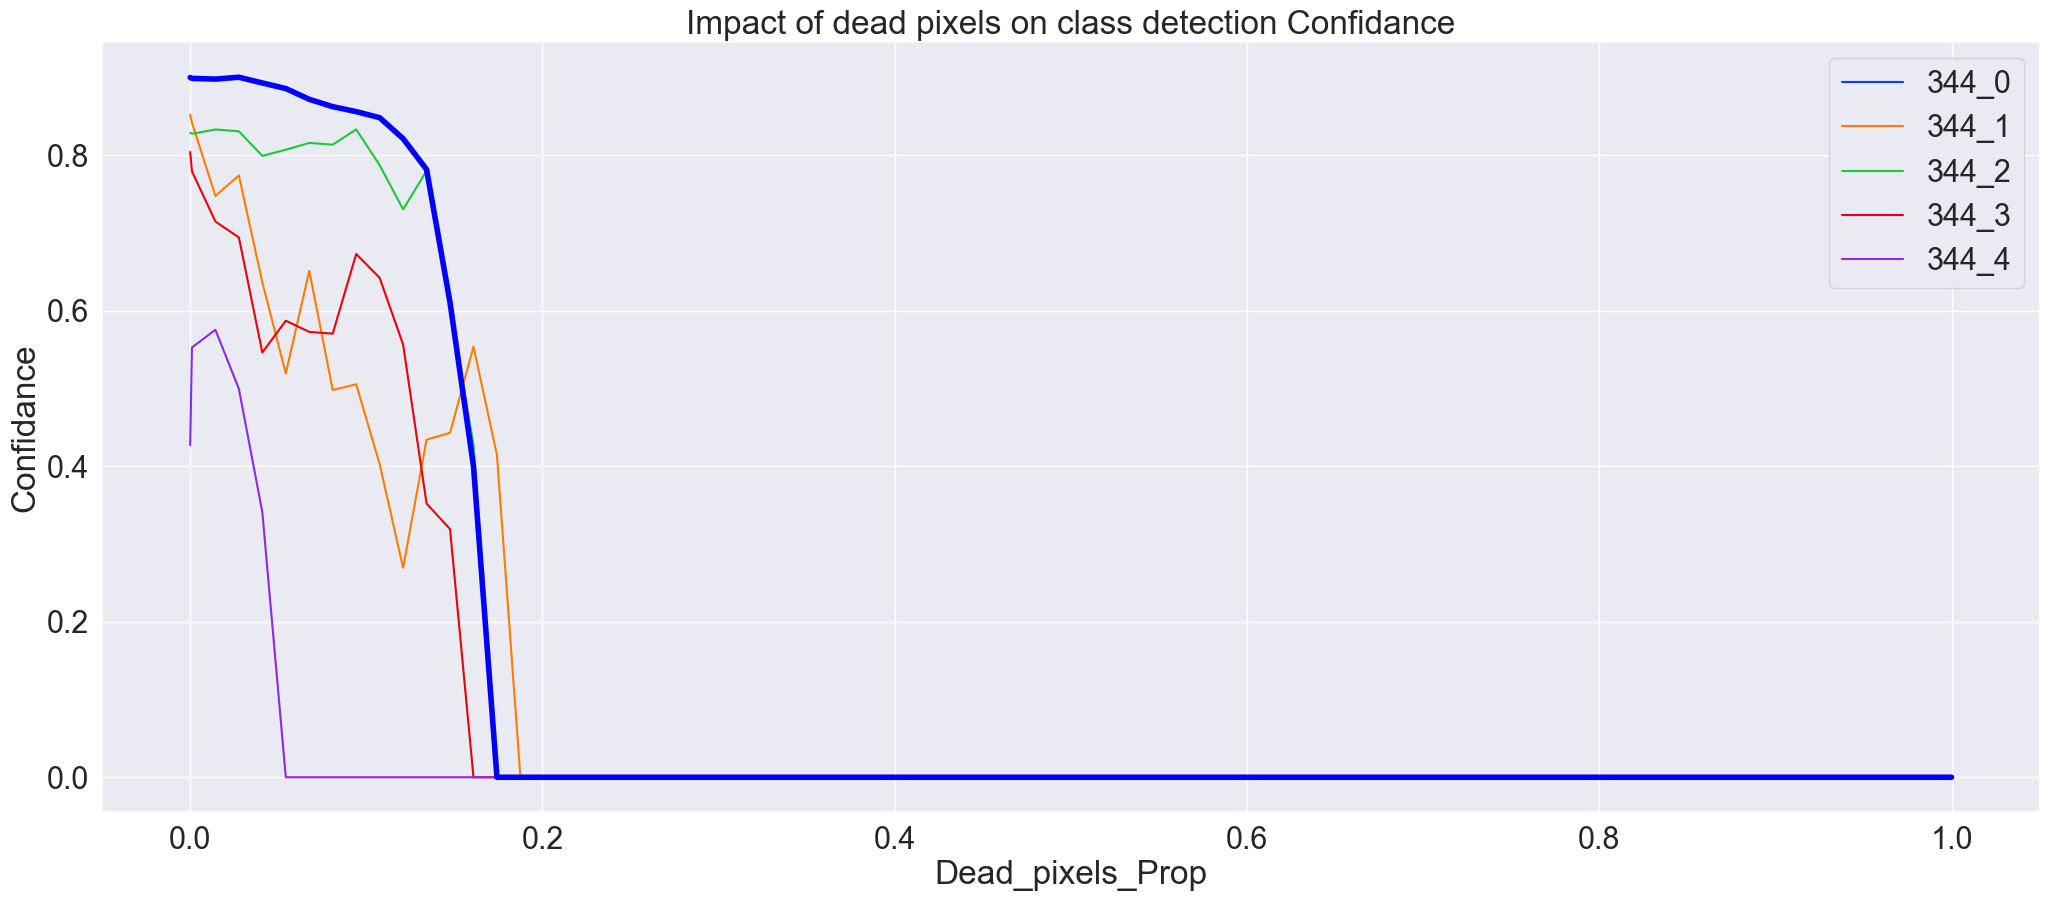

In [22]:
plt.figure(figsize=(25,10))
sns.set(font_scale=2.0)
sns.lineplot(x='Dead_pixels_Prop', y='Confidance',hue='unique_id', estimator=None, data=df_344,palette="bright").set_title("Impact of dead pixels on class detection Confidance")

bold_id = '344_0'
bold_line_data = df_344[df_344['unique_id'] == bold_id]
sns.lineplot(x='Dead_pixels_Prop', y='Confidance', data=bold_line_data, color='blue', linewidth=4)  # Adjust color and linewidth as needed

plt.show()

## 344 Image-blured study

In [23]:
df_344_blured=pd.read_excel(excel_file,sheet_name="Blur_study_344")

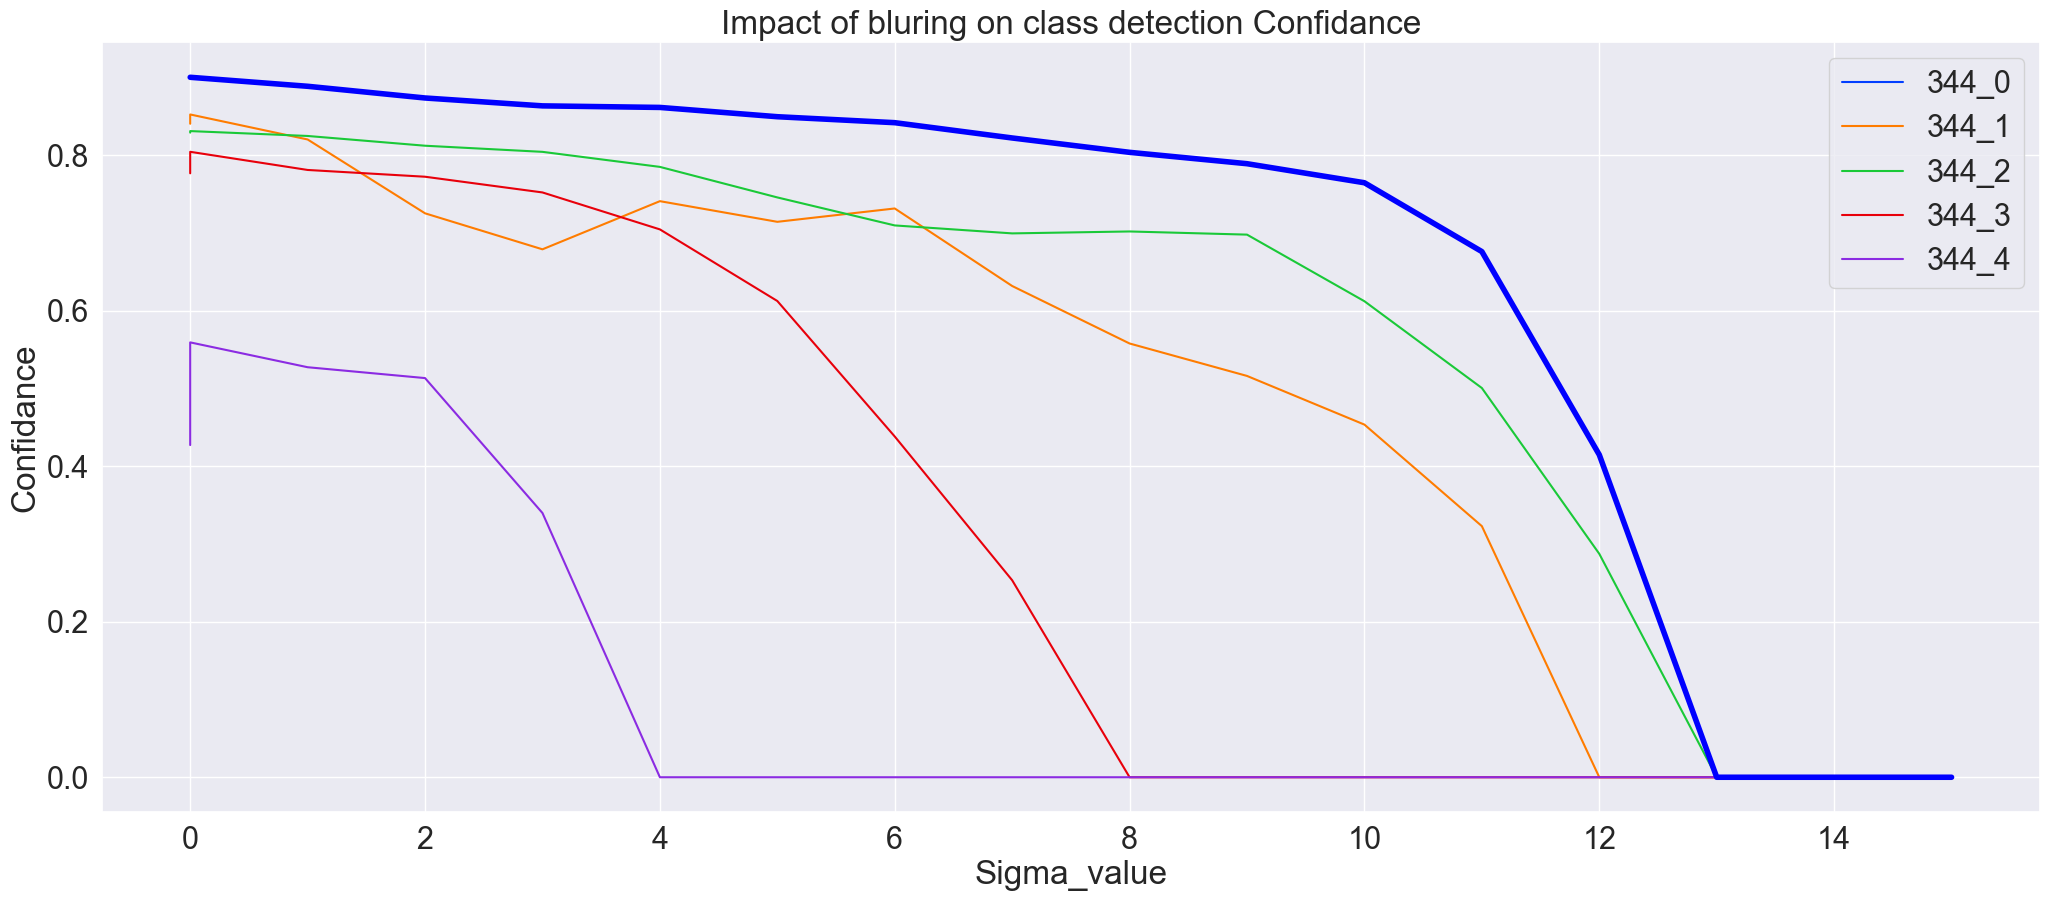

In [24]:
plt.figure(figsize=(25,10))
sns.set(font_scale=2.0)
sns.lineplot(x='Sigma_value', y='Confidance',hue='unique_id', estimator=None, data=df_344_blured,palette="bright").set_title("Impact of bluring on class detection Confidance")
bold_id = '344_0'
bold_line_data = df_344_blured[df_344_blured['unique_id'] == bold_id]
sns.lineplot(x='Sigma_value', y='Confidance', data=bold_line_data, color='blue', linewidth=4)  # Adjust color and linewidth as needed
plt.show()

## 344 Image-Pnoise study

In [ ]:
df_344_pnoise=pd.read_excel(excel_file,sheet_name="Pnoise_study_normal_344")

In [ ]:
plt.figure(figsize=(25,10))
sns.set(font_scale=2.0)
sns.lineplot(x='K_value', y='Confidance',hue='unique_id', estimator=None, data=df_344_pnoise,palette="bright").set_title("Impact of poisson noise on class detection Confidance")
bold_id = '344_0'
bold_line_data = df_344_pnoise[df_344_pnoise['unique_id'] == bold_id]
sns.lineplot(x='K_value', y='Confidance', data=bold_line_data, color='blue', linewidth=4)  # Adjust color and linewidth as needed
plt.show()

## 344 Image-Gnoise study

In [ ]:
df_344_gnoise=pd.read_excel(excel_file,sheet_name="Gnoise_study_344")

In [ ]:
plt.figure(figsize=(25,10))
sns.set(font_scale=2.0)
sns.lineplot(x='Sigma_value', y='Confidance',hue='unique_id', estimator=None, data=df_344_gnoise,palette="bright").set_title("Impact of gaussian noise on class detection Confidance")
bold_id = '344_0'
bold_line_data = df_344_gnoise[df_344_gnoise['unique_id'] == bold_id]
sns.lineplot(x='Sigma_value', y='Confidance', data=bold_line_data, color='blue', linewidth=4)  # Adjust color and linewidth as needed
plt.show()